In [10]:
import subprocess
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict


sns.set(style="whitegrid")

![Image](images/original.png) 

![Image](bert-like-before.png) 

![Image](bert-like-after.png) 

In [11]:
configs = [
    ("DD", "0"),
    ("SparseDense", "0"),
    ("SparseDense", "1"),
]
sparsities = ["0.10", "0.3", "0.5", "0.7", "0.9"]

repeats = 5
binary = "../../build/benchmark"
graph_name = "bert"

In [12]:
def parse_output(output):
    metrics = {}
    lines = output.strip().splitlines()
    for line in lines:
        if "analysis" in line:
            metrics["analysis"] = float(line.split("=")[-1].strip())
        elif "load graph" in line:
            metrics["load"] = float(line.split("=")[-1].strip())
        elif "compilation" in line:
            metrics["compilation"] = float(line.split("=")[-1].strip())
        elif "runtime" in line:
            metrics["runtime"] = float(line.split("=")[-1].strip())
        elif "memory used" in line:
            metrics["memory"] = float(line.split("=")[-1].strip())
        elif "before" in line:
            metrics["before"] = float(line.split("=")[-1].strip())
        elif "after" in line:
            metrics["after"] = float(line.split("=")[-1].strip())
    return metrics

def load(file_name: str):
    results = []
    #odel, row, col, format, prop, before, after, analysis, load, comp, run, memory
    #bert,0.10, 0.10, DD, 0, 0.151571, 0.151571, 0.0, 2.722863, 0.7594678, 4.706985, 489.7921
    with open(file_name, "rt") as file:
        for line in file.readlines()[1:]:
            data = line.replace(' ', '').split(',')
            sparsity = float(data[1])
            fmt = data[3]
            opt = data[4]
            analysis = float(data[7])
            load = float(data[8])
            comp = float(data[9])
            runtime = float(data[10])
            memory = float(data[11].replace('\n', ''))
            mean_metrics = {
                "config": f"{sparsity},{sparsity},{fmt},opt={opt}",
                "analysis": analysis, "load": load, "compilation": comp, "runtime": runtime, "memory": memory
            }
            results.append(mean_metrics)
    return results

def run():
    results = []
    with open(f"{graph_name}-{datetime.now()}.out", "wt") as file:
        file.write("model, row, col, format, prop, before, after, analysis, load, comp, run, memory\n")
        for fmt, opt in configs:
            for sparsity in sparsities:
                times = {"analysis": [], "load": [], "compilation": [], "runtime": [], "memory": []}
                for _ in range(repeats):
                    cmd = [binary, "graph", graph_name, sparsity, sparsity, fmt, opt]
                    result = subprocess.run(cmd, capture_output=True, text=True)
                    metrics = parse_output(result.stdout)
                    for k in times:
                        times[k].append(metrics.get(k, 0.0))
        
                mean_metrics = {k: statistics.mean(times[k]) for k in times}
                mean_metrics["config"] = f"{sparsity},{sparsity},{fmt},opt={opt}"
                result_line = f'{graph_name},{sparsity}, {sparsity}, {fmt}, {opt}, {metrics["before"]}, {metrics["after"]}, {mean_metrics["analysis"]}, {mean_metrics["load"]}, {mean_metrics["compilation"]}, {mean_metrics["runtime"]}, {mean_metrics["memory"]}'
                print(result_line, end='\r')
                file.write(f'{result_line}\n')
                results.append(mean_metrics)
    return results

In [13]:
def plot(data):
    # === Legend mapping ===
    legend_map = {
        "SparseDense,opt=1": "sparse+prop",
        "SparseDense,opt=0": "sparse",
        "DD,opt=0": "dense",
    }

    # === Organize data ===
    configs = defaultdict(lambda: {"ratios": [], "runtime": [], "memory": [], "analysis": [], "compilation": []})
    ratio_labels = []

    for entry in data:
        # Extract ratio and config name
        parts = entry["config"].split(",")
        ratio = f"({parts[0]},{parts[1]})"
        config_type = ",".join(parts[2:])  # e.g., "DD,opt=0"
        label = legend_map.get(config_type, config_type)

        if ratio not in ratio_labels:
            ratio_labels.append(ratio)

        configs[label]["ratios"].append(ratio)
        configs[label]["runtime"].append(entry["runtime"])
        configs[label]["memory"].append(entry["memory"])
        configs[label]["analysis"].append(entry["analysis"])
        configs[label]["compilation"].append(entry["compilation"])

    # Sort ratio_labels (by numeric value)
    def ratio_key(r):
        vals = r.strip("()").split(",")
        return float(vals[0]), float(vals[1])
    ratio_labels = sorted(ratio_labels, key=ratio_key)

    # Create index for x-axis
    x = np.arange(len(ratio_labels))

    # === 1) Runtime plot ===
    plt.figure(figsize=(8, 5))
    for label, values in configs.items():
        # Align runtime values according to ratio_labels order
        runtime_values = [v for _, v in sorted(zip(values["ratios"], values["runtime"]), key=lambda x: ratio_key(x[0]))]
        plt.plot(x, runtime_values, label=label)
    plt.xticks(x, ratio_labels, rotation=45)
    plt.ylabel("Runtime (s)")
    plt.title("Runtime vs Ratios")
    plt.legend()
    plt.tight_layout()
    #plt.savefig("runtime_plot.png")
    #plt.close()
    plt.plot()

    # === 2) Memory plot ===
    plt.figure(figsize=(8, 5))
    for label, values in configs.items():
        memory_values = [v for _, v in sorted(zip(values["ratios"], values["memory"]), key=lambda x: ratio_key(x[0]))]
        plt.plot(x, memory_values, label=label)
    plt.xticks(x, ratio_labels, rotation=45)
    plt.ylabel("Memory (MB)")
    plt.title("Memory Usage vs Ratios")
    plt.legend()
    plt.tight_layout()
    #plt.savefig("memory_plot.png")
    plt.plot()
    #plt.close()

    # === 3) Analysis vs Compilation vs Runtime (bar chart) ===
    width = 0.25
    bar_positions = np.arange(len(ratio_labels))
    
    for label, values in configs.items():
        if label != "sparse+prop":
            continue
        analysis_values = [v for _, v in sorted(zip(values["ratios"], values["analysis"]), key=lambda x: ratio_key(x[0]))]
        comp_values = [v for _, v in sorted(zip(values["ratios"], values["compilation"]), key=lambda x: ratio_key(x[0]))]
        runtime_values = [v for _, v in sorted(zip(values["ratios"], values["runtime"]), key=lambda x: ratio_key(x[0]))]

        plt.figure(figsize=(10, 6))
        plt.bar(bar_positions - width, analysis_values, width, label="analysis")
        plt.bar(bar_positions, comp_values, width, label="compilation")
        plt.bar(bar_positions + width, runtime_values, width, label="runtime")
        plt.xticks(bar_positions, ratio_labels, rotation=45)
        plt.ylabel("Time (s)")
        plt.title(f"Analysis vs Compilation vs Runtime ({label})")
        plt.legend()
        plt.tight_layout()
        #plt.savefig(f"time_breakdown_{label.replace('+','_')}.png")
        #plt.close()
        plt.plot()

In [14]:
def plotly(data):
    legend_map = {
        "SparseDense,opt=1": "sparse+prop",
        "SparseDense,opt=0": "sparse",
        "DD,opt=0": "dense",
    }

    configs = defaultdict(lambda: {"ratios": [], "runtime": [], "memory": [], "analysis": [], "compilation": []})
    ratio_labels = []

    for entry in data:
        parts = entry["config"].split(",")
        ratio = f"({parts[0]},{parts[1]})"
        config_type = ",".join(parts[2:])
        label = legend_map.get(config_type, config_type)

        if ratio not in ratio_labels:
            ratio_labels.append(ratio)

        configs[label]["ratios"].append(ratio)
        configs[label]["runtime"].append(entry["runtime"])
        configs[label]["memory"].append(entry["memory"])
        configs[label]["analysis"].append(entry["analysis"])
        configs[label]["compilation"].append(entry["compilation"])

    def ratio_key(r):
        vals = r.strip("()").split(",")
        return float(vals[0]), float(vals[1])
    ratio_labels = sorted(ratio_labels, key=ratio_key)

    # Create subplots
    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=False,
                        vertical_spacing=0.15,
                        subplot_titles=("Runtime vs Sparsity Ratio",
                                        "Memory Usage vs Sparsity Ratio",
                                        "Analysis vs Compilation vs Runtime (sparsity+prop)"))
    fig.layout.template = "plotly_white"
    # === 1) Runtime Plot (row 1) ===
    for label, values in configs.items():
        runtime_values = [v for _, v in sorted(zip(values["ratios"], values["runtime"]), key=lambda x: ratio_key(x[0]))]
        fig.add_trace(
            go.Scatter(x=ratio_labels, y=runtime_values, mode="lines", name=f"Runtime ({label})", legendgroup="runtime"),
            row=1, col=1
        )

    # === 2) Memory Plot (row 2) ===
    for label, values in configs.items():
        memory_values = [v for _, v in sorted(zip(values["ratios"], values["memory"]), key=lambda x: ratio_key(x[0]))]
        fig.add_trace(
            go.Scatter(x=ratio_labels, y=memory_values, mode="lines", name=f"Memory ({label})", legendgroup="memory"),
            row=2, col=1
        )

    # === 3) Analysis vs Compilation vs Runtime (Bars) (row 3) ===
    # To avoid clutter, show aggregated bars (sum over configs)
    for label, values in configs.items():
        if label != "sparse+prop":
            continue
        analysis_values = [v for _, v in sorted(zip(values["ratios"], values["analysis"]), key=lambda x: ratio_key(x[0]))]
        comp_values = [v for _, v in sorted(zip(values["ratios"], values["compilation"]), key=lambda x: ratio_key(x[0]))]
        runtime_values = [v for _, v in sorted(zip(values["ratios"], values["runtime"]), key=lambda x: ratio_key(x[0]))]

        fig.update_yaxes(type="log", row=3, col=1)

        fig.add_trace(
            go.Bar(name=f"Analysis ({label})", x=ratio_labels, y=analysis_values, legendgroup="bar"),
            row=3, col=1
        )
        fig.add_trace(
            go.Bar(name=f"Compilation ({label})", x=ratio_labels, y=comp_values, legendgroup="bar"),
            row=3, col=1
        )
        fig.add_trace(
            go.Bar(name=f"Runtime ({label})", x=ratio_labels, y=runtime_values, legendgroup="bar"),
            row=3, col=1
        )

    # Layout adjustments
    fig.update_layout(
        height=1000,
        title_text="Benchmark Results",
        barmode='group',
        legend_tracegroupgap=300
    )
    fig.update_xaxes(title_text="Row/Col Sparsity Ratio", row=1, col=1)
    fig.update_xaxes(title_text="Row/Col Sparsity Ratio", row=2, col=1)
    fig.update_xaxes(title_text="Row/Col Sparsity Ratio", row=3, col=1)
    fig.update_yaxes(title_text="Runtime (s)", row=1, col=1)
    fig.update_yaxes(title_text="Memory (MB)", row=2, col=1)
    fig.update_yaxes(title_text="Log-scale Time (s)", row=3, col=1)

    fig.show()


In [24]:
def plotly_sparsity(data):
    configs = defaultdict(lambda: {"ratios": [], "runtime": []})
    ratio_labels = set()

    for entry in data:
        parts = entry["config"].split(",")
        config_type = ",".join(parts[2:])
        
        if config_type != "SparseDense,opt=1":
            continue

        if parts[0] != "0.0" and parts[1] != "0.0":
            label = "row/col"
            ratio = parts[0]
        elif parts[0] != "0.0":
            label = "row"
            ratio = parts[0]
        else:
            label = "col"
            ratio = parts[1]

        ratio_labels.add(ratio)
        configs[label]["ratios"].append(ratio)
        configs[label]["runtime"].append(entry["runtime"])

    ratio_labels = sorted(ratio_labels, key=lambda r: float(r))

    fig = go.Figure()
    for label, values in configs.items():
        sorted_data = sorted(zip(values["ratios"], values["runtime"]), key=lambda x: float(x[0]))
        sorted_ratios, sorted_runtimes = zip(*sorted_data)

        fig.add_trace(go.Scatter(
            x=sorted_ratios,
            y=sorted_runtimes,
            mode="lines",
            name=label
        ))

    fig.update_layout(
        title="Runtime vs Sparsity Ratio (Sparse+Prop)",
        xaxis_title="Sparsity Ratio",
        yaxis_title="Runtime (s)",
        template="plotly_white",
        height=500,
        legend=dict(
            title="Sparsity Type",
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )

    fig.show()


In [70]:
#data = run()
#data = random_run()
data = load("row_col_no_input.out")
#data = load("col_sparsity_batch_warmup.txt")
#data = load("row_col_sparsity_batch_warmup.txt")
#data.extend(load("col_sparsity_batch_warmup.txt"))
#data.extend(load("row_col_sparsity_batch_warmup.txt"))

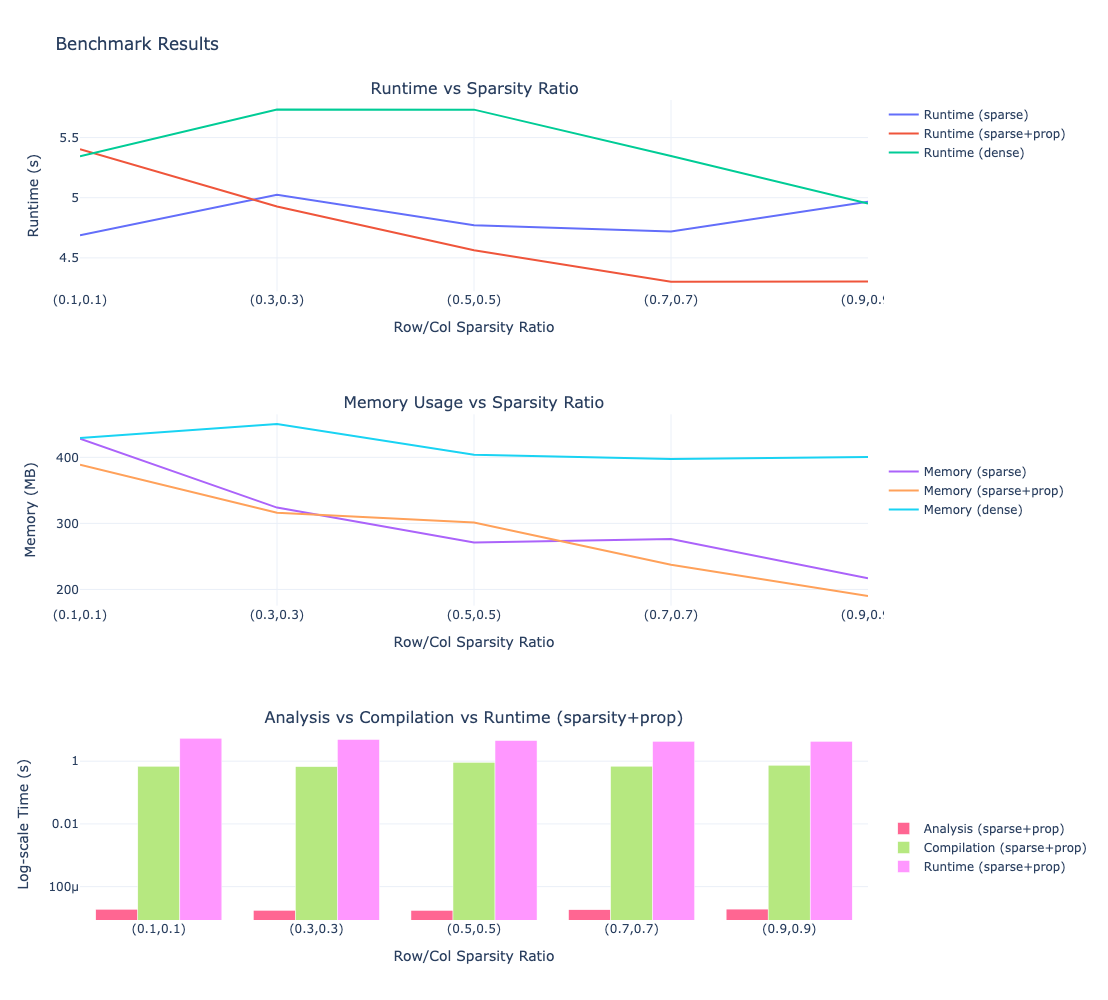

In [71]:
plotly(data)

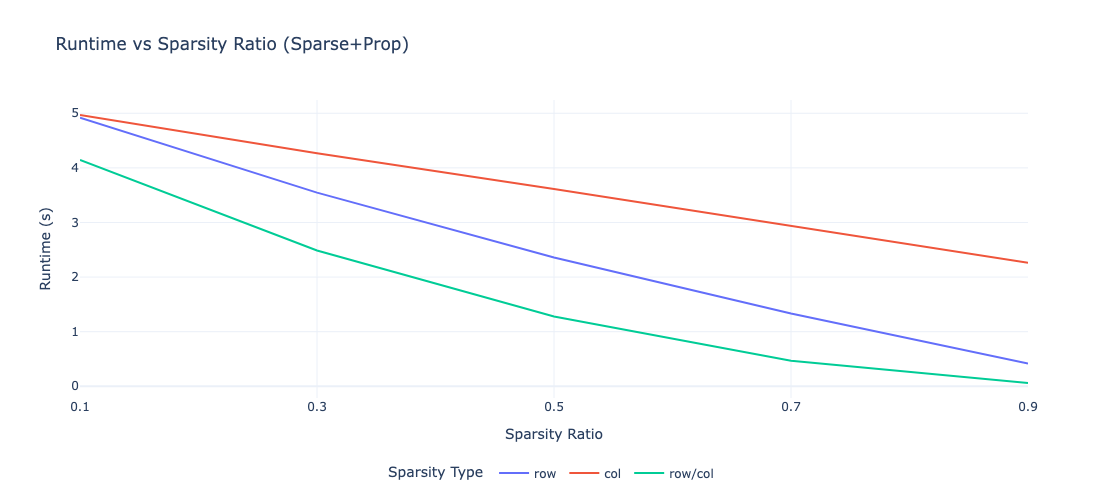

In [67]:
#load("bert-2025-07-23 14:11:01.913977.out")